## Imports

In [ ]:
import os
import io
import imageio
import ipywidgets
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

# Setting seed for reproducibility
SEED = 42
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
keras.utils.set_random_seed(SEED)

## Train

In [ ]:
!pip install -qq medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:

# def run_experiment():
#     # Initialize model
#     model = create_vivit_classifier_model3(
#         tubelet_embedder=TubeletEmbeddingModel3(
#             embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
#         ),
#         positional_encoder=PositionalEncoderModel3(embed_dim=PROJECTION_DIM),
#     )

#     # Compile the model with the optimizer, loss function
#     # and the metrics.
#     optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
#     model.compile(
#         optimizer=optimizer,
#         loss="sparse_categorical_crossentropy",
#         metrics=[
#             keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
#             keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
#         ],
#     )

#     # Train the model.
#     _ = model.fit(trainloader, epochs=EPOCHS, validation_data=validloader)

#     _, accuracy, top_5_accuracy = model.evaluate(testloader)
#     print(f"Test accuracy: {round(accuracy * 100, 2)}%")
#     print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

#     return model


# # model = run_experiment()

In [ ]:
#MED MNIST
import medmnist

# DATA
DATASET_NAME = "organmnist3d"
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (28, 28, 28, 1)
NUM_CLASSES = 11

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 60

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 8
NUM_LAYERS = 8

In [ ]:

class TubeletEmbeddingModel3(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        # flattened_patches = self.flatten(projected_patches)
        return projected_patches



class PositionalEncoderModel3(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens



def create_vivit_classifier_model3(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):

    # print(f"Input shape:{input_shape}")
    inputs = layers.Input(shape=input_shape)

    # Create patches.
    patches = tubelet_embedder(inputs)
    # print(f"patches shape:{patches.shape}")

    #dimensions
    batch_size, num_tokens_along_time, num_tokens_along_height, num_tokens_along_width, token_dim = patches.shape

    patches = layers.Reshape((num_tokens_along_time, num_tokens_along_height * num_tokens_along_width, token_dim))(patches)
    
    # print(f"patches shape:{patches.shape}")
    
    # Encode patches.
    encoded_patches = positional_encoder(patches)
 
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        # print(f"Spatial Input shape:{encoded_patches.shape}")
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Temporal Attention
        x_temp = layers.Permute((2, 1, 3))(x2)
        # print(f"Temporal_input shape:{x_temp.shape}")


        x_temp1 = layers.LayerNormalization(epsilon=1e-6)(x_temp)
        attention_output_temp = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x_temp1, x_temp1)

        # Skip connection
        x_temp2 = layers.Add()([attention_output_temp, x_temp])


        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x_temp2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x_temp2])
        encoded_patches = layers.Permute((2, 1, 3))(encoded_patches)
    # print(f"AttentionBlocks output shape:{encoded_patches.shape}")

    encoded_patches = layers.Reshape(target_shape=(-1, embed_dim))(encoded_patches)

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:

def download_and_prepare_dataset(data_info: dict):
    """Utility function to download the dataset.

    Arguments:
        data_info (dict): Dataset metadata.
    """
    data_path = keras.utils.get_file(origin=data_info["url"], md5_hash=data_info["MD5"])

    with np.load(data_path) as data:
        # Get videos
        train_videos = data["train_images"]
        valid_videos = data["val_images"]
        test_videos = data["test_images"]

        # Get labels
        train_labels = data["train_labels"].flatten()
        valid_labels = data["val_labels"].flatten()
        test_labels = data["test_labels"].flatten()

    return (
        (train_videos, train_labels),
        (valid_videos, valid_labels),
        (test_videos, test_labels),
    )


# Get the metadata of the dataset
info = medmnist.INFO[DATASET_NAME]

# Get the dataset
prepared_dataset = download_and_prepare_dataset(info)
(train_videos, train_labels) = prepared_dataset[0]
(valid_videos, valid_labels) = prepared_dataset[1]
(test_videos, test_labels) = prepared_dataset[2]

@tf.function
def preprocess(frames: tf.Tensor, label: tf.Tensor):
    """Preprocess the frames tensors and parse the labels."""
    # Preprocess images
    frames = tf.image.convert_image_dtype(
        frames[
            ..., tf.newaxis
        ],  # The new axis is to help for further processing with Conv3D layers
        tf.float32,
    )
    # Parse label
    label = tf.cast(label, tf.float32)
    return frames, label


def prepare_dataloader(
    videos: np.ndarray,
    labels: np.ndarray,
    loader_type: str = "train",
    batch_size: int = BATCH_SIZE,
):
    """Utility function to prepare the dataloader."""
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))

    if loader_type == "train":
        dataset = dataset.shuffle(BATCH_SIZE * 2)

    dataloader = (
        dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    return dataloader


trainloader = prepare_dataloader(train_videos, train_labels, "train")
validloader = prepare_dataloader(valid_videos, valid_labels, "valid")
testloader = prepare_dataloader(test_videos, test_labels, "test")

32657407/32657407 [==============================] - 10s 0us/step


In [ ]:

class TubeletEmbeddingModel3(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        # flattened_patches = self.flatten(projected_patches)
        return projected_patches



class PositionalEncoderModel3(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens



def create_vivit_classifier_model3(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):

    # print(f"Input shape:{input_shape}")
    inputs = layers.Input(shape=input_shape)

    # Create patches.
    patches = tubelet_embedder(inputs)
    # print(f"patches shape:{patches.shape}")

    #dimensions
    batch_size, num_tokens_along_time, num_tokens_along_height, num_tokens_along_width, token_dim = patches.shape

    patches = layers.Reshape((num_tokens_along_time, num_tokens_along_height * num_tokens_along_width, token_dim))(patches)
    
    # print(f"patches shape:{patches.shape}")
    
    # Encode patches.
    encoded_patches = positional_encoder(patches)
 
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        # print(f"Spatial Input shape:{encoded_patches.shape}")
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Temporal Attention
        x_temp = layers.Permute((2, 1, 3))(x2)
        # print(f"Temporal_input shape:{x_temp.shape}")


        x_temp1 = layers.LayerNormalization(epsilon=1e-6)(x_temp)
        attention_output_temp = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x_temp1, x_temp1)

        # Skip connection
        x_temp2 = layers.Add()([attention_output_temp, x_temp])


        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x_temp2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x_temp2])
        encoded_patches = layers.Permute((2, 1, 3))(encoded_patches)
    # print(f"AttentionBlocks output shape:{encoded_patches.shape}")

    encoded_patches = layers.Reshape(target_shape=(-1, embed_dim))(encoded_patches)

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
!pip install backend


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for backend: filename=backend-0.2.4.1-py3-none-any.whl size=6423 sha256=29695b3fb976992791b9dcc03ecbaa32c5fcfe7f287a190f13601424ac1cdfbd
  Stored in directory: /root/.cache/pip/wheels/42/57/e7/47a2068145b8516ed8c663a4e1cb5ecd617f490c5705d5368a
Successfully built backend


In [ ]:
import keras.backend as K

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))

In [ ]:

# Initialize model
model = create_vivit_classifier_model3(
    tubelet_embedder=TubeletEmbeddingModel3(
        embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
    ),
    positional_encoder=PositionalEncoderModel3(embed_dim=PROJECTION_DIM),
)

# Compile the model with the optimizer, loss function
# and the metrics.
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        # keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),precision,recall,f1score

    ],
)

# Train the model.
history = model.fit(trainloader, epochs=EPOCHS, validation_data=validloader)





Epoch 1/60
31/31 [==============================] - 60s 162ms/step - loss: 2.4086 - accuracy: 0.1327 - val_loss: 2.2463 - val_accuracy: 0.1553
Epoch 2/60
31/31 [==============================] - 2s 68ms/step - loss: 2.1343 - accuracy: 0.1759 - val_loss: 1.8579 - val_accuracy: 0.2422
Epoch 3/60
31/31 [==============================] - 2s 68ms/step - loss: 1.9739 - accuracy: 0.2449 - val_loss: 1.8361 - val_accuracy: 0.2919
Epoch 4/60
31/31 [==============================] - 2s 65ms/step - loss: 1.9217 - accuracy: 0.2469 - val_loss: 1.6828 - val_accuracy: 0.3416
Epoch 5/60
31/31 [==============================] - 3s 95ms/step - loss: 1.8154 - accuracy: 0.2737 - val_loss: 1.5744 - val_accuracy: 0.3975
Epoch 6/60
31/31 [==============================] - 2s 67ms/step - loss: 1.6980 - accuracy: 0.3354 - val_loss: 1.3828 - val_accuracy: 0.3975
Epoch 7/60
31/31 [==============================] - 2s 68ms/step - loss: 1.4607 - accuracy: 0.4362 - val_loss: 1.3042 - val_accuracy: 0.4472
Epoch 8/60


In [ ]:
eval_metrics = model.evaluate(testloader)
eval_metrics

20/20 [==============================] - 1s 23ms/step - loss: 1.1595 - accuracy: 0.7344


[1.1595041751861572, 0.7344262003898621]

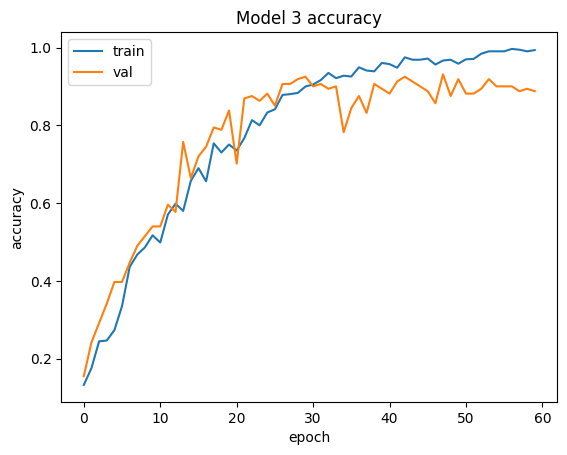

In [ ]:
import keras
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model 3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

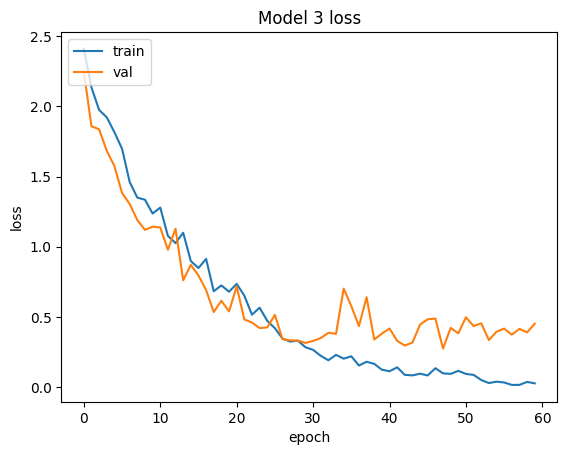

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model 3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
NUM_SAMPLES_VIZ = 100
testsamples, labels = next(iter(trainloader))
testsamples, labels = testsamples[:NUM_SAMPLES_VIZ], labels[:NUM_SAMPLES_VIZ]

ground_truths = []
preds = []
videos = []

for step, (x_batch_train, y_batch_train) in enumerate(testloader):

# for i, (testsample, label) in enumerate(zip(testsamples, labels)):
    # # Generate gif
    # with io.BytesIO() as gif:
    #     imageio.mimsave(gif, (testsample.numpy() * 255).astype("uint8"), "GIF", fps=5)
    #     videos.append(gif.getvalue())

    # Get model prediction
    output = model.predict(x_batch_train)
    pred = np.argmax(output, axis=1)

    for i in y_batch_train.numpy().astype("int"):
        ground_truths.append(i)
    # ground_truths.append(y_batch_train.numpy().astype("int"))
    for i in pred:
        preds.append(i)


1/1 [==============================] - 0s 35ms/step


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import confusion_matrix


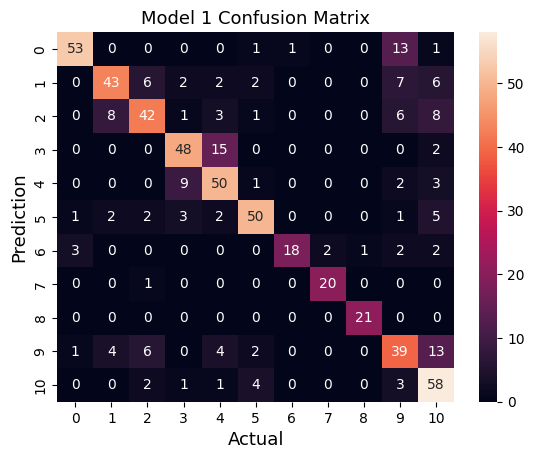

In [ ]:
cm=confusion_matrix(ground_truths, preds)
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13) 
plt.title('Model 1 Confusion Matrix',fontsize=13)
plt.show()

In [ ]:
print(ground_truths)
print(preds)

[10, 2, 3, 4, 9, 7, 5, 2, 4, 3, 0, 2, 3, 8, 5, 5, 1, 10, 1, 10, 9, 0, 9, 5, 8, 9, 1, 5, 7, 5, 10, 4, 1, 3, 1, 3, 8, 7, 3, 5, 1, 1, 4, 3, 0, 4, 3, 3, 0, 4, 4, 5, 9, 3, 10, 0, 10, 2, 1, 9, 1, 3, 4, 9, 8, 1, 8, 1, 7, 2, 4, 10, 9, 2, 5, 8, 5, 9, 0, 8, 0, 4, 4, 9, 1, 2, 2, 3, 10, 2, 0, 5, 1, 4, 0, 2, 2, 5, 3, 2, 10, 6, 5, 5, 5, 1, 0, 0, 4, 7, 2, 8, 3, 10, 10, 4, 10, 10, 3, 2, 5, 5, 3, 0, 9, 9, 1, 1, 10, 0, 6, 3, 9, 1, 4, 1, 7, 1, 3, 1, 8, 1, 10, 3, 2, 1, 9, 2, 5, 7, 5, 9, 1, 3, 2, 1, 10, 5, 8, 10, 4, 2, 5, 0, 1, 4, 0, 4, 2, 5, 2, 4, 2, 2, 1, 6, 4, 10, 1, 3, 10, 5, 8, 3, 3, 9, 6, 4, 1, 4, 3, 4, 10, 0, 4, 3, 3, 4, 5, 5, 4, 3, 6, 9, 2, 3, 2, 9, 5, 0, 10, 9, 3, 9, 5, 9, 0, 3, 6, 10, 10, 4, 10, 2, 9, 2, 0, 5, 2, 6, 5, 1, 5, 3, 2, 10, 2, 2, 4, 6, 1, 4, 0, 0, 4, 4, 1, 7, 4, 5, 10, 2, 4, 9, 3, 2, 3, 10, 5, 10, 8, 0, 5, 1, 6, 3, 6, 10, 9, 9, 4, 7, 2, 1, 10, 0, 8, 3, 5, 5, 5, 0, 1, 2, 2, 0, 8, 5, 6, 0, 3, 1, 10, 3, 9, 7, 9, 5, 10, 1, 0, 2, 9, 9, 1, 1, 0, 5, 3, 5, 10, 10, 6, 0, 3, 7, 2, 3, 10, 5, 6, 2